In [12]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
#print('Using PyTorch version:', torch.__version__, ' Device:', device)

In [13]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [14]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


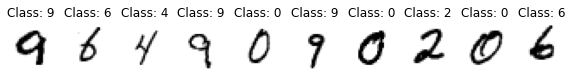

In [15]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [17]:
def train(epoch, losst, acct,  log_interval=200):
    # Set model to training mode
    model.train()
    
    total_loss = 0.0
    total_correct = 0
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == target).sum().item()
        
        #if batch_idx % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.data.item()))
            
    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = total_correct / len(train_loader.dataset)

    losst.append(avg_loss) 
    acct.append(accuracy*100.)
    #print(avg_loss)
    #print(accuracy)

In [18]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    #print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #val_loss, correct, len(validation_loader.dataset), accuracy))

In [19]:
%%time
epochs = 50

lossv, accv = [], []
losst, acct = [], []
for epoch in range(1, epochs + 1):
    train(epoch, losst, acct)
    validate(lossv, accv)

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

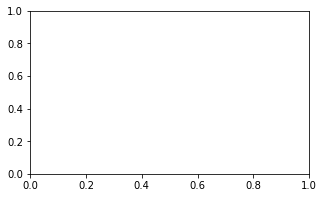

In [20]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), losst)
plt.title('train loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), acct)
plt.title('train accuracy')